# Bài Tập cuối kỳ





In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd

# ---------------------------- DEVICE ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------- UTILS ----------------------------
def load_image_file(uploaded_file, max_size=512, shape=None):
    image = Image.open(uploaded_file).convert("RGB")
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    else:
        size = min(max(image.size), max_size)
        image.thumbnail((size, size), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])
    return transform(image).unsqueeze(0).to(device)

def im_convert(tensor, max_display_size=400):
    image = tensor.clone().detach().cpu().squeeze(0)
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    image = image * std + mean
    image = torch.clamp(image,0,1)
    img = transforms.ToPILImage()(image)
    img.thumbnail((max_display_size, max_display_size), Image.LANCZOS)
    return img

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(b, c, h*w)
    return torch.bmm(tensor, tensor.transpose(1,2)) / (c*h*w)

# ---------------------------- FEATURE EXTRACTOR ----------------------------
class VGGFeatures(nn.Module):
    def __init__(self, content_layers, style_layers):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        self.vgg = nn.Sequential(*list(vgg.children())[:29]).to(device).eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.content_layers = content_layers
        self.style_layers = style_layers

    def forward(self, x):
        content_features, style_features = {}, {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                style_features[name] = x
        return content_features, style_features

# ---------------------------- STREAMLIT APP ----------------------------
st.set_page_config(page_title="🎨 Neural Style Transfer", layout="wide")
st.title("🎨 Neural Style Transfer - Chuyển Phong Cách Nghệ Thuật")

# ---------------------------- Session state ----------------------------
if 'c_losses' not in st.session_state: st.session_state.c_losses = []
if 's_losses' not in st.session_state: st.session_state.s_losses = []
if 'target_img' not in st.session_state: st.session_state.target_img = None
if 'step' not in st.session_state: st.session_state.step = 0
if 'loss_table' not in st.session_state: st.session_state.loss_table = pd.DataFrame(columns=["Step","Total Loss","Content Loss","Style Loss"])

# ---------------------------- Tabs ----------------------------
tab1, tab2, tab3 = st.tabs(["Upload & Settings", "Training Progress", "Result & Download"])

# ---------------------------- Tab 1: Upload & Settings ----------------------------
with tab1:
    st.sidebar.header("📂 Upload Ảnh")
    content_file = st.sidebar.file_uploader("Upload Ảnh Nội Dung", type=["jpg","png","jpeg"])
    style_file = st.sidebar.file_uploader("Upload Ảnh Phong Cách", type=["jpg","png","jpeg"])

    st.sidebar.header("⚙️ Tham số")
    steps_choice = st.sidebar.selectbox("Số bước tối ưu hóa", [300,400,500,600], index=0)
    alpha = st.sidebar.slider("Trọng số Nội Dung (α)", 0.1, 10.0, 1.0, 0.1, help="α lớn hơn → giữ nội dung rõ hơn")
    beta = st.sidebar.slider("Trọng số Phong Cách (β)", 1e3, 1e5, 1e4, 1e3, help="β lớn hơn → phong cách đậm hơn")
    display_size = st.sidebar.slider("Kích thước hiển thị kết quả", 200, 800, 400, 50, help="Chọn kích thước preview ảnh kết quả")

    start_button = st.sidebar.button("🎯 Bắt đầu chuyển phong cách")
    reset_button = st.sidebar.button("♻️ Reset tất cả")

# ---------------------------- Reset ----------------------------
if reset_button:
    st.session_state.c_losses = []
    st.session_state.s_losses = []
    st.session_state.target_img = None
    st.session_state.step = 0
    st.session_state.loss_table = pd.DataFrame(columns=["Step","Total Loss","Content Loss","Style Loss"])
    st.experimental_rerun()

# ---------------------------- Start NST ----------------------------
if start_button:
    if content_file is None or style_file is None:
        st.error("Vui lòng tải cả Ảnh Nội Dung và Ảnh Phong Cách!")
        st.stop()

    content = load_image_file(content_file)
    style = load_image_file(style_file, shape=tuple(content.shape[-2:][::-1]))

    # Preview Content & Style
    with tab1:
        st.subheader("📷 Ảnh Nội Dung & Phong Cách")
        cols = st.columns(2)
        cols[0].image(im_convert(content, display_size), caption="Ảnh Nội Dung", use_column_width=False)
        cols[1].image(im_convert(style, display_size), caption="Ảnh Phong Cách", use_column_width=False)

    # Setup extractor
    content_layers = ["21"]
    style_layers = ["0","5","10","19","28"]
    extractor = VGGFeatures(content_layers, style_layers)
    content_feat, _ = extractor(content)
    style_feat = extractor(style)[1]
    style_grams = {l: gram_matrix(style_feat[l]) for l in style_layers}

    # Initialize target
    target = content.clone().requires_grad_(True).to(device)
    optimizer = torch.optim.LBFGS([target], max_iter=1)
    pbar = st.progress(0)

    # ---------------------------- Tab 2: Training Progress ----------------------------
    with tab2:
        st.subheader("⚡ Quá trình tối ưu hóa")
        step_metric = st.metric("Step hiện tại", 0)

        st.session_state.c_losses = []
        st.session_state.s_losses = []
        st.session_state.loss_table = pd.DataFrame(columns=["Step","Total Loss","Content Loss","Style Loss"])

        for step in range(steps_choice):
            def closure():
                optimizer.zero_grad()
                t_content, t_style = extractor(target)
                c_loss = torch.mean((t_content["21"] - content_feat["21"])**2)
                s_loss = 0
                for l in style_layers:
                    s_loss += torch.mean((gram_matrix(t_style[l]) - style_grams[l])**2)
                loss = alpha*c_loss + beta*s_loss
                loss.backward()

                # Store
                st.session_state.c_losses.append(c_loss.item())
                st.session_state.s_losses.append(s_loss.item())
                total_loss = alpha*c_loss.item() + beta*s_loss.item()
                st.session_state.loss_table.loc[len(st.session_state.loss_table)] = [step+1,total_loss,c_loss.item(),s_loss.item()]
                step_metric.metric("Step hiện tại", step+1)
                return loss

            optimizer.step(closure)
            pbar.progress((step+1)/steps_choice)

        st.success("✅ Hoàn tất chuyển phong cách!")

        st.session_state.target_img = target

# ---------------------------- Tab 3: Result & Download ----------------------------
with tab3:
    if st.session_state.target_img is not None:
        st.subheader("🖼️ Ảnh Kết Quả")
        st.image(im_convert(st.session_state.target_img, display_size),
                 caption="Ảnh Sau Khi Chuyển Phong Cách", use_column_width=False)

        buf = BytesIO()
        im_convert(st.session_state.target_img, display_size).save(buf, format="PNG")
        st.download_button("⬇️ Tải Ảnh Kết Quả", data=buf.getvalue(),
                           file_name="stylized.png", mime="image/png")

        # Loss plot
        st.subheader("📈 Biểu đồ Loss")
        fig, ax = plt.subplots()
        ax.plot(st.session_state.c_losses, label="Content Loss", color="blue")
        ax.plot(st.session_state.s_losses, label="Style Loss", color="red")
        ax.set_xlabel("Step")
        ax.set_ylabel("Loss")
        ax.legend()
        st.pyplot(fig)

        # Bảng thống kê 100 step gần nhất
        st.subheader("📊 Thống kê Loss (100 step gần nhất)")
        st.dataframe(st.session_state.loss_table.tail(100), use_container_width=True)

    else:
        st.info("Chưa có kết quả. Vui lòng chạy NST ở tab Upload & Settings.")


Overwriting app.py


In [ ]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 148.9 MB/s eta 0:00:00


In [ ]:
!ngrok config add-authtoken 33XzMWuEzakeuxnB6brJBWUnXNB_3vqJtZVihToGSoY33VJZM

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# 1️⃣ Kill tunnel cũ
from pyngrok import ngrok
ngrok.kill()

# 2️⃣ Chạy Streamlit background (port 8502)
!nohup streamlit run app.py --server.port 8502 > streamlit.log 2>&1 &

# 3️⃣ Chờ Streamlit khởi động (5-10s)
import time
time.sleep(8)

# 4️⃣ Mở ngrok cho port 8502
public_url = ngrok.connect(8502)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://unexcellent-oversparing-leroy.ngrok-free.dev" -> "http://localhost:8502"


In [ ]:
!curl https://unexcellent-oversparing-leroy.ngrok-free.dev



<!--
 Copyright (c) Streamlit Inc. (2018-2022) Snowflake Inc. (2022-2025)

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->

<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="UTF-8" />
    <meta
      name="viewport"
      content="width=device-width, initial-scale=1, shrink-to-fit=no"
    />
    <link rel="shortcut icon" href="./favicon.png" />
    <link
      rel="preload"
      href="./static/media/SourceSansVF-Upright.ttf.BsWL4Kly.woff2"
      as="font"
      type="font/woff2"
      crossorig

In [ ]:
!tail -f streamlit.log


For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-10-20 09:18:48.488 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
2025-10-20 09:18:48.505 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
2025-10-20 09:19:56.477 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
2025-10-20 09:19:56.689 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.


^C


🚀 Training NST...
Epoch 1, Step 0: Total Loss=695488.94, Style Loss=695488.93750, Content Loss=0.00, Step Time=2.36s
Epoch 1, Step 10: Total Loss=138266.91, Style Loss=133186.90625, Content Loss=5080.00, Step Time=0.00s
Epoch 1, Step 20: Total Loss=70102.79, Style Loss=64803.71875, Content Loss=5299.07, Step Time=0.00s
Epoch 1, Step 30: Total Loss=45383.09, Style Loss=40132.40625, Content Loss=5250.68, Step Time=0.00s
Epoch 1, Step 40: Total Loss=33318.57, Style Loss=28198.71875, Content Loss=5119.85, Step Time=0.00s
Epoch 2, Step 0: Total Loss=26457.06, Style Loss=21578.02148, Content Loss=4879.04, Step Time=0.00s
Epoch 2, Step 10: Total Loss=22252.16, Style Loss=17667.07617, Content Loss=4585.09, Step Time=0.00s
Epoch 2, Step 20: Total Loss=19492.69, Style Loss=15189.08789, Content Loss=4303.60, Step Time=0.00s
Epoch 2, Step 30: Total Loss=17549.18, Style Loss=13450.81445, Content Loss=4098.36, Step Time=0.00s
Epoch 2, Step 40: Total Loss=16086.28, Style Loss=12157.28027, Content Los

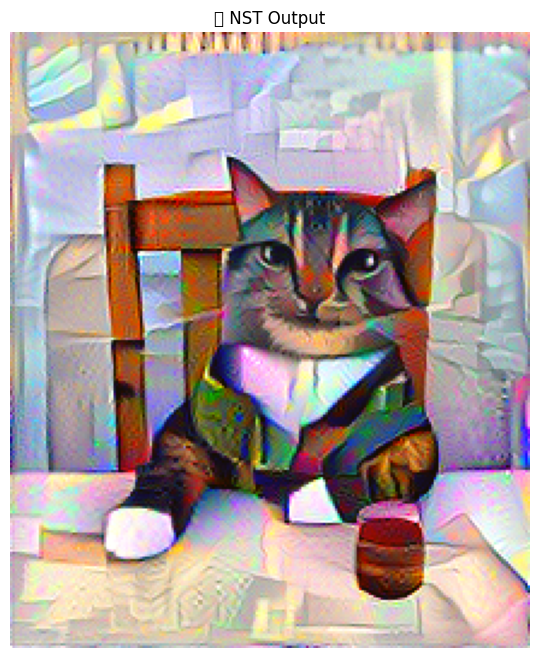

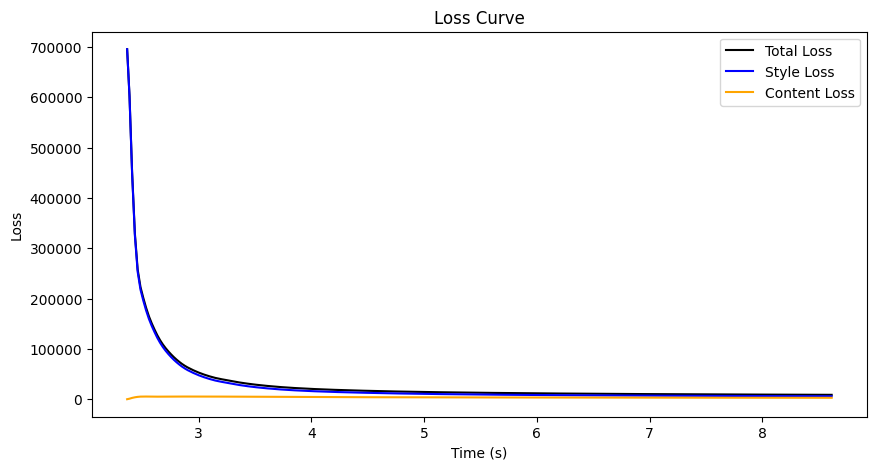

✅ Kết luận:
- Mô hình NST này không cần huấn luyện thêm, dựa trên quá trình tối ưu hóa trực tiếp.
- Content Loss (lớp nông) giữ nội dung gốc, Style Loss (Gram matrix các lớp sâu) giữ phong cách nghệ thuật.
- Cân bằng giữa Content và Style ảnh hưởng lớn đến kết quả cuối cùng (thay đổi style_weight/content_weight).
- Ảnh đầu ra có chi tiết tốt hơn khi tăng kích thước, nhưng thời gian xử lý cũng lâu hơn.
- Đồ thị Loss cho thấy Total Loss giảm dần, Style Loss chiếm phần lớn, Content Loss nhỏ nhưng giữ được cấu trúc nội dung.


In [ ]:
# =========================================================
# 🎨 Neural Style Transfer - TensorFlow + Time + Graph + Conclusion
# =========================================================

import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as kp_image
import numpy as np
import requests, io
from PIL import Image
import matplotlib.pyplot as plt
import time

# ---------------- CONFIG ----------------
content_weight = 1.0
style_weight   = 1.0
img_height     = 256

content_url = "https://i.pinimg.com/1200x/a7/dc/0c/a7dc0c847e97a7f57da17b3de6b8e06f.jpg"
style_url   = "https://i.pinimg.com/736x/59/43/a4/5943a4ddcc6f0d0a86fcdbbb768ad8ad.jpg"

# ---------------- PREPROCESS ----------------
def load_and_process_img(url):
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    img = Image.open(io.BytesIO(response.content)).convert("RGB")
    w = int(img.width * img_height / img.height)
    img = img.resize((w, img_height))
    x = kp_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = vgg19.preprocess_input(x)
    return x

def deprocess_img(x):
    x = x.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

content_img = load_and_process_img(content_url)
style_img   = load_and_process_img(style_url)

# ---------------- MODEL VGG19 ----------------
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_layers = ['block5_conv2']
    style_layers   = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    return Model(vgg.input, outputs), style_layers, content_layers

model, style_layers, content_layers = get_model()

# ---------------- FEATURE EXTRACTION ----------------
def get_features(model, content, style):
    content_out = model(content)
    style_out   = model(style)
    style_feats   = [style_out[i] for i in range(len(style_layers))]
    content_feats = [content_out[i+len(style_layers)] for i in range(len(content_layers))]
    return style_feats, content_feats

style_features, content_features = get_features(model, content_img, style_img)

# ---------------- GRAM MATRIX ----------------
def gram_matrix(x):
    b, h, w, c = x.shape
    x = tf.reshape(x, (h*w, c))
    return tf.linalg.matmul(x, x, transpose_a=True) / tf.cast(h*w*c, tf.float32)

gram_style_features = [gram_matrix(f) for f in style_features]

# ---------------- LOSS ----------------
def compute_loss(init_image):
    model_outputs = model(init_image)
    style_out  = model_outputs[:len(style_layers)]
    content_out = model_outputs[len(style_layers):]

    style_score = 0
    content_score = 0
    for sf, so in zip(gram_style_features, style_out):
        style_score += tf.reduce_mean(tf.square(gram_matrix(so) - sf))
    style_score /= len(style_layers)

    for cf, co in zip(content_features, content_out):
        content_score += tf.reduce_mean(tf.square(co - cf))
    content_score /= len(content_layers)

    total_loss = style_weight*style_score + content_weight*content_score
    return total_loss, style_score, content_score

# ---------------- OPTIMIZATION ----------------
opt = tf.keras.optimizers.Adam(learning_rate=5.0)
init_image = tf.Variable(content_img, dtype=tf.float32)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        total_loss, s_loss, c_loss = compute_loss(init_image)
    grads = tape.gradient(total_loss, init_image)
    opt.apply_gradients([(grads, init_image)])
    init_image.assign(tf.clip_by_value(init_image, -103.939, 151.061))
    return total_loss, s_loss, c_loss

# ---------------- TRAINING ----------------
epochs = 5
steps_per_epoch = 50

# Lists to store loss values for plotting
total_loss_list = []
style_loss_list = []
content_loss_list = []
time_list = []

print("🚀 Training NST...")
start_time = time.time()
for n in range(epochs):
    for m in range(steps_per_epoch):
        step_start = time.time()
        total_loss, s_loss, c_loss = train_step()
        step_end = time.time()
        elapsed = step_end - step_start

        total_loss_list.append(total_loss.numpy())
        style_loss_list.append(s_loss.numpy())
        content_loss_list.append(c_loss.numpy())
        time_list.append(time.time() - start_time)

        if m % 10 == 0:
            print(f"Epoch {n+1}, Step {m}: Total Loss={total_loss.numpy():.2f}, "
                  f"Style Loss={s_loss.numpy():.5f}, Content Loss={c_loss.numpy():.2f}, Step Time={elapsed:.2f}s")

end_time = time.time()
print(f"✅ Training completed in {end_time - start_time:.2f}s")

# ---------------- SHOW RESULT ----------------
plt.figure(figsize=(8,8))
plt.imshow(deprocess_img(init_image.numpy()))
plt.axis('off')
plt.title("🎨 NST Output")
plt.show()

# ---------------- PLOT LOSS ----------------
plt.figure(figsize=(10,5))
plt.plot(time_list, total_loss_list, label='Total Loss', color='black')
plt.plot(time_list, style_loss_list, label='Style Loss', color='blue')
plt.plot(time_list, content_loss_list, label='Content Loss', color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# ---------------- CONCLUSION ----------------
print("✅ Kết luận:")
print("- Mô hình NST này không cần huấn luyện thêm, dựa trên quá trình tối ưu hóa trực tiếp.")
print("- Content Loss (lớp nông) giữ nội dung gốc, Style Loss (Gram matrix các lớp sâu) giữ phong cách nghệ thuật.")
print("- Cân bằng giữa Content và Style ảnh hưởng lớn đến kết quả cuối cùng (thay đổi style_weight/content_weight).")
print("- Ảnh đầu ra có chi tiết tốt hơn khi tăng kích thước, nhưng thời gian xử lý cũng lâu hơn.")
print("- Đồ thị Loss cho thấy Total Loss giảm dần, Style Loss chiếm phần lớn, Content Loss nhỏ nhưng giữ được cấu trúc nội dung.")
